# Task 1 : Set up colab gpu runtime environment

In [6]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.1/102.1 KB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 KB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=4a883a03b20a216107e362d99c9b45ee308262880f62776880c08328b5b75be1
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=709ba62226427fc7e796bb0ff94f49a14224de899629084e20511f34a9b9f097
  Stored in directory: /root/.cache/pip/wheels/ed/fa/b9/5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfully bu

# Download Dataset

original author of the dataset :

https://github.com/VikramShenoy97/Human-Segmentation-Dataset

In [1]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 34.90 MiB/s, done.
Resolving deltas: 100% (3/3), done.


# Import Libraries 

In [2]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [3]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

#  Setup Configurations

In [4]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv' # Contains the images & corresponding masks
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0' 
WEIGHTS = 'imagenet'

In [5]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


# Inspect data

In [6]:
row = df.iloc[10]
image_path = row.images
mask_path = row.masks

In [7]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/ 255.0

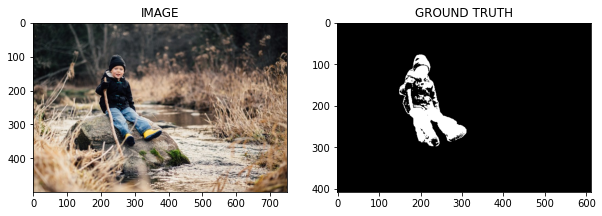

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

**Split the data**

In [9]:
train_df, valid_df =  train_test_split(df,test_size = 0.2, random_state = 42)

# Data Augmentation Functions

For instance and semantic segmentation tasks, you need to augment both the input image and one or more output masks.

Albumentations ensures that the input image and the output mask will receive the same set of augmentations with the same parameters.



albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ],is_check_shapes = False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ],is_check_shapes = False)

# **Create Custom Dataset**

We need to create a pytorch dataset to load image & mask in pairs. 

In [12]:
from torch.utils.data import Dataset

In [14]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  #this returns the image & mask pairs according the the index

  def __getitem__(self, index):

    row = self.df.iloc[index]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # (H,W,C)
    

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (H, W)
    mask = np.expand_dims(mask, axis = -1) # (H,W,C)

    if self.augmentations:
      #print(image.shape, mask.shape, image_path)
      data = self.augmentations(image = image, mask = mask)
      image= data['image']
      mask = data['mask']
      

    #pytorch expects (C,H,W) we have in (H,W,C)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask,(2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask

In [15]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset =  SegmentationDataset(valid_df, get_valid_augs())

In [16]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


In [18]:
'''
An utulity function to display image &  mask
'''
import matplotlib.pyplot as plt 
import numpy as np 
import torch

def show_image(image,mask,pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        


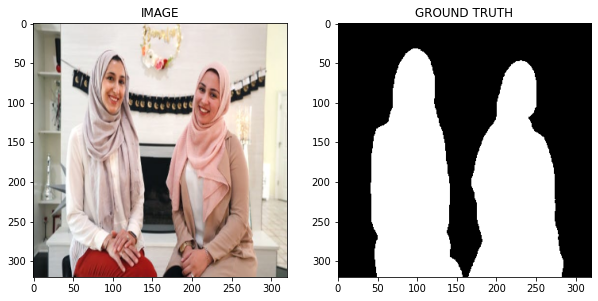

In [21]:
idx = 55
image, mask = trainset[idx]
show_image(image, mask) # helper.show_image(image, mask)

# Load dataset into batches

In [22]:
from torch.utils.data import DataLoader

In [23]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [24]:
print(f'Number of batches in tranloader : {len(trainloader)}')
print(f'Number of batches in validloader : {len(validloader)}')

Number of batches in tranloader : 15
Number of batches in validloader : 4


In [25]:
for image,mask in trainloader:
  break

In [26]:
print(f'Image batch shape {image.shape}')
print(f'Mask batch shape {mask.shape}')

Image batch shape torch.Size([16, 3, 320, 320])
Mask batch shape torch.Size([16, 1, 320, 320])


# Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [37]:
from torch import nn
import segmentation_models_pytorch as smp 
from segmentation_models_pytorch.losses import DiceLoss

In [38]:
class SegmenetationModel(nn.Module):
  
  def __init__(self):
    super(SegmenetationModel, self).__init__()
    self.arc = smp.Unet(
        encoder_name= ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3, 
        classes= 1, 
        activation=None,
    )

  def forward(self,images, masks=None):
    logits = self.arc(images)
    

    if masks !=None:
      loss1 = DiceLoss(mode='binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [39]:
model = SegmenetationModel()
model.to(DEVICE);

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Create Train and Validation Function

In [40]:
def train_fn(dataloader, model, optimizer):
  model.train()
  total_loss = 0

  for images, masks in tqdm(dataloader):
    
    images = images.to(DEVICE)    
    masks = masks.to(DEVICE)   

    optimizer.zero_grad()
    logits , loss = model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(dataloader)

In [41]:
def eval_fn(dataloader, model, optimizer):
  model.eval()
  total_loss = 0

  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images = images.to(DEVICE)  
      masks = masks.to(DEVICE)  

      logits, loss = model(images, masks)
      total_loss += loss.item()

  return total_loss/len(dataloader)

## Train Model

In [42]:
optimizer = torch.optim.Adam(model.parameters(), lr= LR)

In [43]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader,model, optimizer)
  valid_loss = eval_fn(validloader,model,optimizer)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(),'best_model.pt')
    print('MODEL SAVED!!')
  print(f'Epoch: {i+1} Train Loss:{train_loss} Valid Loss{valid_loss}')

100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


MODEL SAVED!!
Epoch: 1 Train Loss:1.0553521513938904 Valid Loss1059.6213989257812


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


MODEL SAVED!!
Epoch: 2 Train Loss:0.8944094618161519 Valid Loss77.88023853302002


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


MODEL SAVED!!
Epoch: 3 Train Loss:0.7993925412495931 Valid Loss1.0851519405841827


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


MODEL SAVED!!
Epoch: 4 Train Loss:0.734938895702362 Valid Loss0.7881075441837311


100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


Epoch: 5 Train Loss:0.6848142663637797 Valid Loss0.8407932072877884


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


Epoch: 6 Train Loss:0.6730743686358134 Valid Loss0.8337264508008957


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


MODEL SAVED!!
Epoch: 7 Train Loss:0.7032655755678813 Valid Loss0.6764455437660217


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


Epoch: 8 Train Loss:0.6551748991012574 Valid Loss0.9177289307117462


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


Epoch: 9 Train Loss:0.6455573558807373 Valid Loss0.7079424858093262


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


Epoch: 10 Train Loss:0.6092758059501648 Valid Loss0.9103145897388458


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


Epoch: 11 Train Loss:0.5974682331085205 Valid Loss0.7840097844600677


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


MODEL SAVED!!
Epoch: 12 Train Loss:0.5581982096036275 Valid Loss0.6682808548212051


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


MODEL SAVED!!
Epoch: 13 Train Loss:0.5819208502769471 Valid Loss0.6005543172359467


100%|██████████| 4/4 [00:01<00:00,  3.66it/s]


Epoch: 14 Train Loss:0.5316406110922496 Valid Loss0.7261529564857483


100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


MODEL SAVED!!
Epoch: 15 Train Loss:0.500941151380539 Valid Loss0.5578700229525566


100%|██████████| 4/4 [00:01<00:00,  3.66it/s]


Epoch: 16 Train Loss:0.467024028301239 Valid Loss0.7037663608789444


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


Epoch: 17 Train Loss:0.5396710077921549 Valid Loss0.6244649738073349


100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Epoch: 18 Train Loss:0.5169754227002462 Valid Loss0.6660803109407425


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


MODEL SAVED!!
Epoch: 19 Train Loss:0.4664620339870453 Valid Loss0.5213842391967773


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


Epoch: 20 Train Loss:0.46775718331336974 Valid Loss0.7078134268522263


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


Epoch: 21 Train Loss:0.4601045747598012 Valid Loss0.6115168333053589


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


MODEL SAVED!!
Epoch: 22 Train Loss:0.43543962637583417 Valid Loss0.44215889275074005


100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


Epoch: 23 Train Loss:0.4403039534886678 Valid Loss0.5304591879248619


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


Epoch: 24 Train Loss:0.3859297792116801 Valid Loss0.5860849171876907


100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

Epoch: 25 Train Loss:0.4155413428942362 Valid Loss0.6884579658508301


# Inference

In [44]:
idx = 5
model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0)) # C,H, W -> (1,C,H,W) includes the batch dimension
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) *1.0 

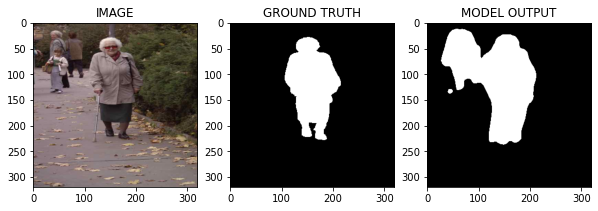

In [45]:
show_image(image,mask,pred_mask.detach().cpu().squeeze(0))